<a href="https://colab.research.google.com/github/hochkofler/Master_big_data/blob/main/TFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Configuración de entorno**

In [122]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import seaborn as sns

# Preprocesado y análisis
# ==============================================================================
from sklearn.model_selection import TimeSeriesSplit
from scipy import stats
from datetime import datetime
from google.colab import files
import itertools

# Metrics
# ==============================================================================
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Modelos
# ==============================================================================
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import make_scorer
mse = make_scorer(mean_squared_error,greater_is_better=False)

# Configuración matplotlib
# ==============================================================================
plt.style.use('seaborn-pastel')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# **1. Obteción de datos**

In [123]:
#uploaded = files.upload()

In [124]:
df_raw = pd.read_csv('/content/drive/MyDrive/datos 010108 a 140521.csv', 
                     index_col=0, header = 0, parse_dates = True,
                     names=['PUNTO', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       'FECHA'])

In [125]:
df_raw = df_raw.melt(id_vars=['FECHA', 'PUNTO'], 
            value_vars=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'],var_name = 'HORA', value_name = 'KWH')

In [126]:
df_raw = df_raw.astype({'HORA': 'int32'})

In [127]:
replace_values = {'C. NO REGULADOS': 'OTROS',
 'CESSA - Mariaca': 'SUCRE',
 'CESSA - Sucre': 'SUCRE',
 'COCHABAMBA': 'COCHABAMBA',
 'CRE - Santa Cruz': 'SANTA CRUZ',
 'CRE(Las Misiones) - Santa Cruz': 'SANTA CRUZ',
 'CUMBRE': 'LA PAZ',
 'DELAPAZ - Cumbre': 'LA PAZ',
 'DELAPAZ - La Paz': 'LA PAZ',
 'DELAPAZ - San BuenaVentura': 'LA PAZ',
 'ELECTROPAZ - La Paz': 'LA PAZ',
 'ELFEC - ChimorÃ©': 'COCHABAMBA',
 'ELFEC - ChimorÃ© - Carrasco': 'COCHABAMBA',
 'ELFEC - Cochabamba': 'COCHABAMBA',
 'ELFEO - Catavi': 'ORURO',
 'ELFEO - Oruro': 'ORURO',
 'EMDECRUZ': 'SANTA CRUZ',
 'EMDEECRUZ': 'SANTA CRUZ',
 'ENDE - DELBENI': 'BENI',
 'ENDE - Varios (2)': 'OTROS',
 'ENDE DELBENI (3)': 'BENI',
 'ENDE DEORURO - Catavi': 'ORURO',
 'ENDE DEORURO - Jeruyo': 'ORURO',
 'ENDE DEORURO - Lucianita': 'ORURO',
 'ENDE DEORURO - Oruro': 'ORURO',
 'LA PAZ': 'LA PAZ',
 'ORURO': 'ORURO',
 'Otros - C. No Regulados': 'OTROS',
 'POTOSI': 'POTOSI',
 'PUNUTUMA (1)': 'POTOSI',
 'SAN BUENAVENTURA': 'LA PAZ',
 'SAN CRISTOBAL': 'POTOSI',
 'SAN CRISTOBAL - C. No Reg.': 'POTOSI',
 'SANTA CRUZ': 'SANTA CRUZ',
 'SEPSA - Atocha': 'POTOSI',
 'SEPSA - Chilcobija': 'POTOSI',
 'SEPSA - Don Diego': 'POTOSI',
 'SEPSA - Portugalete': 'POTOSI',
 'SEPSA - PotosÃ\xad': 'POTOSI',
 'SEPSA - Punutuma': 'POTOSI',
 'SEPSA - Telamayu': 'POTOSI',
 'SEPSA - Torre Huayco': 'POTOSI',
 'SETAR - Tarija': 'TARIJA',
 'SETAR - Villamontes': 'TARIJA',
 'SETAR - Yacuiba': 'TARIJA',
 'SUCRE': 'SUCRE',
 'VARIOS (2)': 'OTROS',
 'Varios (1)': 'OTROS',
 'ELFEC - Chimoré':'COCHABAMBA',
 'SEPSA - Potosí': 'POTOSI',
 'TARIJA':'TARIJA', 
 'BENI':'BENI',
 'DELAPAZ - San Buenaventura': 'LA PAZ',
 'ELFEC - Chimoré - Carrasco': 'COCHABAMBA'}

In [128]:
df_raw['DEPARTAMENTO'] = df_raw.replace({"PUNTO": replace_values})['PUNTO']

In [129]:
replace_values_zonas = {'SANTA CRUZ':'ORIENTE', 
                        'LA PAZ':'OCCIDENTE', 'COCHABAMBA':'CENTRO',
                        'ORURO':'OCCIDENTE', 'SUCRE':'CENTRO', 'POTOSI':'OCCIDENTE',
       'OTROS':'CENTRO', 'TARIJA':'CENTRO', 'BENI':'ORIENTE'}

In [130]:
df_raw['ZONA'] = df_raw.replace({"DEPARTAMENTO": \
replace_values_zonas})['DEPARTAMENTO']

In [131]:
df_raw['year'] = pd.DatetimeIndex(df_raw['FECHA']).year
df_raw['month'] = pd.DatetimeIndex(df_raw['FECHA']).month
df_raw['day'] = pd.DatetimeIndex(df_raw['FECHA']).day
df_raw['hour']= df_raw['HORA']-1
df_raw['FECHA'] = pd.to_datetime(df_raw[['year', 'month', 'day', 
                                         'hour']])
df_raw['FECHA'] = pd.to_datetime(df_raw['FECHA'])

In [132]:
df_raw = df_raw.drop(['year', 'month', 'day', 'hour'], axis=1)

In [133]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2249304 entries, 0 to 2249303
Data columns (total 6 columns):
 #   Column        Dtype         
---  ------        -----         
 0   FECHA         datetime64[ns]
 1   PUNTO         object        
 2   HORA          int32         
 3   KWH           float64       
 4   DEPARTAMENTO  object        
 5   ZONA          object        
dtypes: datetime64[ns](1), float64(1), int32(1), object(3)
memory usage: 94.4+ MB


In [134]:
data = df_raw.copy()
data = data.groupby(['FECHA', 'ZONA','DEPARTAMENTO'], 
                    as_index=False)['KWH'].sum()
data.set_index(['FECHA'], inplace=True)
#======================================================
train_full = data[data.index.year < 2020]
test = data[data.index.year >= 2020]
train_full_bolivia = train_full.resample('h').sum()['KWH']
test_bolivia = test.resample('h').sum()['KWH']

# **2. EDA**



In [135]:
pd.DataFrame(train_full_bolivia).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105192 entries, 2008-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   KWH     105192 non-null  float64
dtypes: float64(1)
memory usage: 1.6 MB


In [136]:
# para encontrar los datos faltantes
np.unique(train_full_bolivia[train_full_bolivia == 0].index.date)

array([datetime.date(2011, 6, 30), datetime.date(2012, 2, 22),
       datetime.date(2012, 5, 4), datetime.date(2012, 5, 5),
       datetime.date(2012, 5, 6), datetime.date(2012, 5, 7),
       datetime.date(2012, 7, 17), datetime.date(2014, 4, 11),
       datetime.date(2014, 4, 12)], dtype=object)

In [137]:
pd.DataFrame(train_full_bolivia.describe()).T

,count,mean,std,min,25%,50%,75%,max
KWH,105192.0,820.927121,221.761658,0.0,658.2,802.5,975.40225,1509.183


In [138]:
train_full.groupby("ZONA")['KWH'].describe().reset_index()

,ZONA,count,mean,std,min,25%,50%,75%,max
0,CENTRO,360816.0,56.779176,51.103151,0.0,22.61000,31.5600,92.10000,246.005
1,OCCIDENTE,314928.0,107.533418,66.785752,8.7,55.00000,88.7105,142.74525,350.732
2,ORIENTE,141672.0,225.893940,146.078887,0.0,27.13275,248.1000,329.80000,658.640


In [139]:
train_full.groupby("DEPARTAMENTO")['KWH'].describe().reset_index()

,DEPARTAMENTO,count,mean,std,min,25%,50%,75%,max
0,BENI,36696.0,17.505299,6.022651,0.0,13.94700,17.6660,21.752000,34.780
1,COCHABAMBA,104976.0,130.042736,34.486472,29.2,104.90000,126.8000,153.452500,246.005
2,LA PAZ,104976.0,186.454137,54.531543,70.1,142.74575,185.8000,226.544500,350.732
3,ORURO,104976.0,48.845372,11.869367,8.7,40.10000,48.0000,56.279071,96.012
4,OTROS,104976.0,22.720248,8.059476,5.3,16.26775,22.3470,27.189250,54.400
5,POTOSI,104976.0,87.300745,13.575725,13.4,81.60000,89.1000,95.515000,130.920
6,SANTA CRUZ,104976.0,298.739444,91.098793,99.7,230.30000,288.3020,357.400000,658.640
7,SUCRE,104976.0,28.793235,8.297409,0.0,22.70000,28.4565,34.200000,61.395
8,TARIJA,45888.0,31.114660,11.150140,2.8,25.05150,31.9035,38.153000,68.930


## **2.1 Line plots**

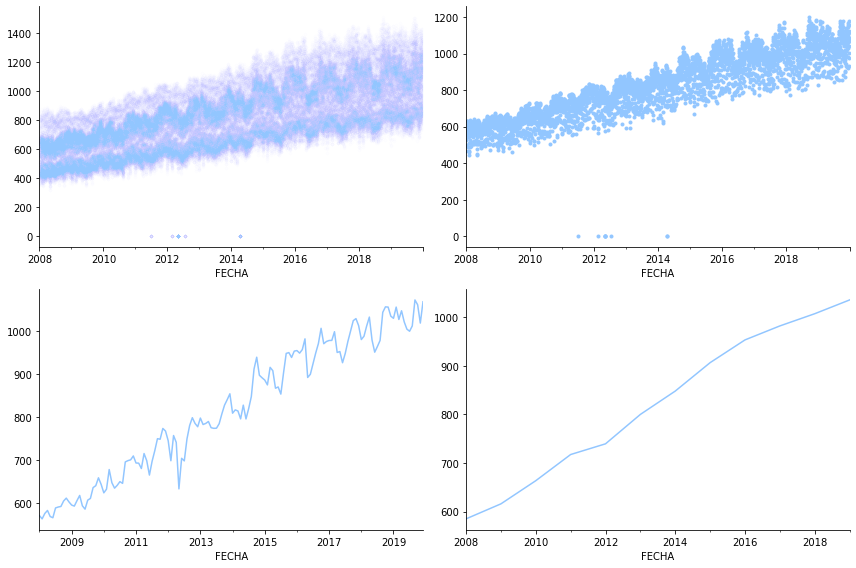

In [140]:
def plot_scatter_by_frec(y, figsize=(12,8)):
  fig = plt.figure(figsize=figsize)
  layout = (2,2)
  h_ax = plt.subplot2grid(layout, (0,0))
  d_ax = plt.subplot2grid(layout, (0,1))
  m_ax = plt.subplot2grid(layout, (1,0))
  a_ax = plt.subplot2grid(layout, (1,1))

  y.resample('a').mean().plot(ax=a_ax)
  y.resample('M').mean().plot(ax=m_ax)
  y.resample('d').mean().plot(ax=d_ax, style = '.')
  y.plot(ax=h_ax, style = '.', alpha = 0.007)
  sns.despine()
  plt.tight_layout()
plot_scatter_by_frec(train_full_bolivia)

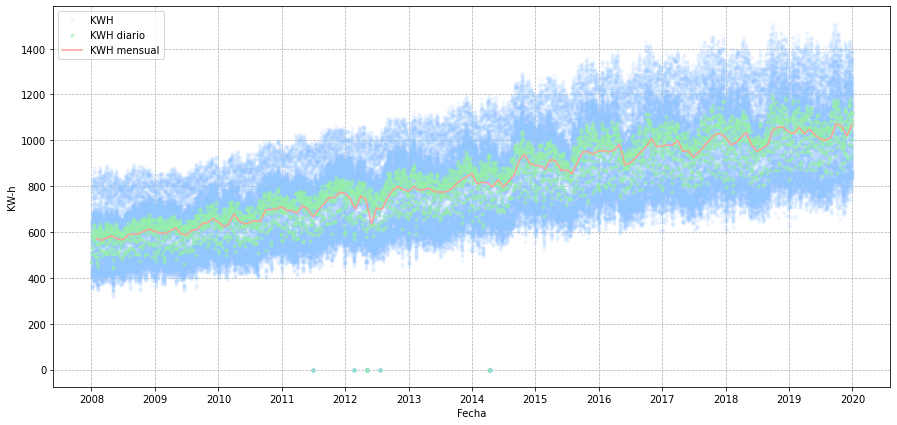

In [141]:
def plot_scatter_by_frec_same_ax(data, figsize=(15, 7), title = None, ax = None):
  if ax == None:
    fig, ax = plt.subplots(figsize=figsize)
  ax.plot(data.resample('h').mean(), '.', label='KWH', alpha=0.1)
  ax.plot(data.resample('d').mean(), '.', label='KWH diario', alpha=0.5)
  ax.plot(data.resample('m').mean(), label='KWH mensual')
  ax.set(xlabel='Fecha', ylabel='KW-h')
  ax.xlim=[0,data.max()]
  ax.grid(linestyle = '--', linewidth = 0.7)

  # Major ticks every 12 months.
  fmt_year = mdates.YearLocator()
  ax.xaxis.set_major_locator(fmt_year)

  # Text in the x axis will be displayed in 'Y' format.
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

  ax.set_title(title)
  leg = ax.legend();
  return ax

plot_scatter_by_frec_same_ax(train_full_bolivia, figsize=(15, 7))


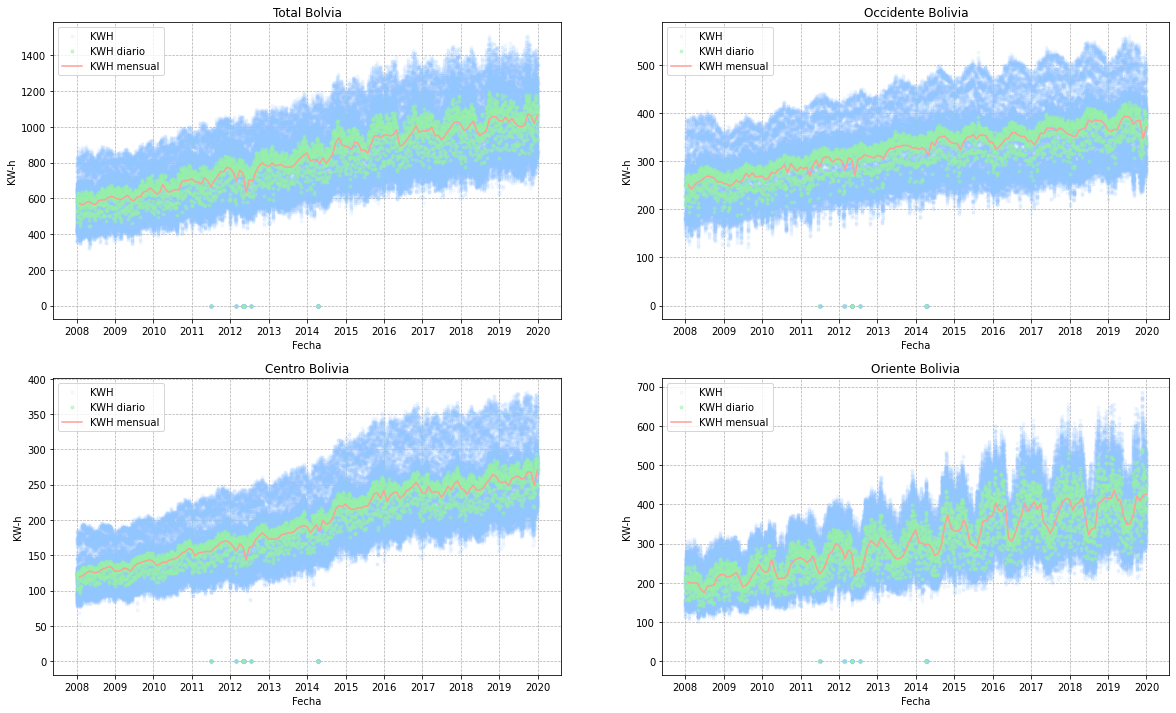

In [142]:
fig, axes = plt.subplots(ncols=2,nrows=2, figsize = (20,12))
plot_scatter_by_frec_same_ax(train_full[train_full.ZONA=='ORIENTE'].resample('h').sum(), figsize=(7, 5), title="Oriente Bolivia", ax=axes[1,1])
plot_scatter_by_frec_same_ax(train_full[train_full.ZONA=='OCCIDENTE'].resample('h').sum(), figsize=(7, 5), title="Occidente Bolivia", ax=axes[0,1])
plot_scatter_by_frec_same_ax(train_full[train_full.ZONA=='CENTRO'].resample('h').sum(), figsize=(7, 5), title="Centro Bolivia", ax=axes[1,0])
plot_scatter_by_frec_same_ax(train_full_bolivia, figsize=(7, 5), title="Total Bolvia", ax=axes[0,0])

## **2.2 Box Plot**

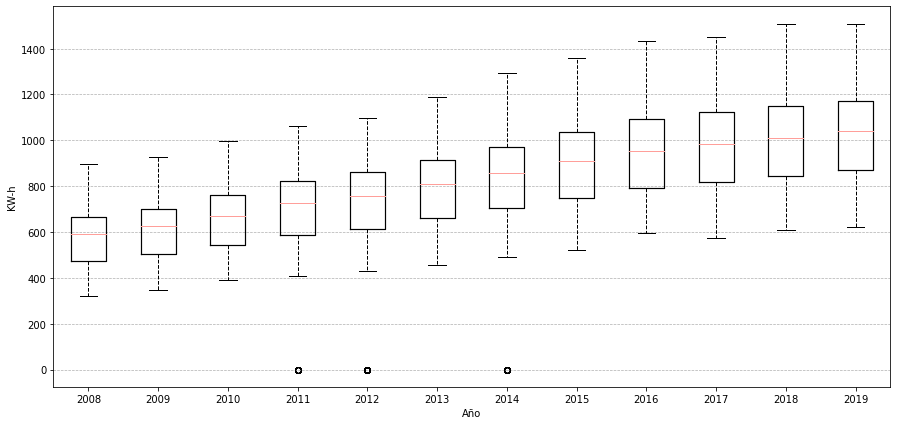

In [143]:
def box_plot_by_year(data, figsize):
  fig, ax = plt.subplots(figsize=figsize)
  df_years = pd.DataFrame()
  for y in data.index.year.unique():
    df_years[y] = data[data.index.year == y].reset_index(drop=True)
  df_years.boxplot(whiskerprops = dict(linestyle='--', linewidth=1), 
                   boxprops= dict(linewidth=1.2), ax= ax)
  ax.set(xlabel='Año', ylabel='KW-h');
  plt.grid(linestyle = '--', linewidth = 0.7)
  plt.grid(axis='x')
  plt.show()
box_plot_by_year(train_full_bolivia, (15,7))

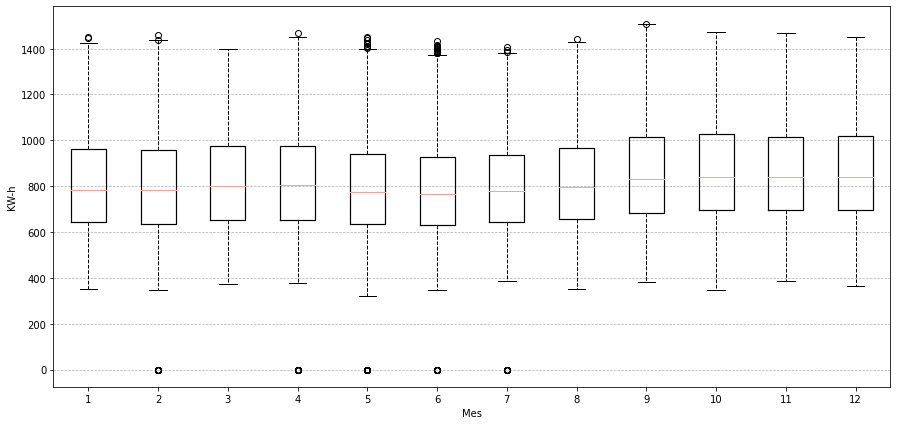

In [144]:
def box_plot_by_month(data, figsize):
  fig, ax = plt.subplots(figsize=figsize)
  df = pd.DataFrame()
  for y in data.index.month.unique():
    df[y] = data[data.index.month == y].reset_index(drop=True)
  df.boxplot(whiskerprops = dict(linestyle='--', linewidth=1), 
                   boxprops= dict(linewidth=1.2), ax= ax)
  ax.set(xlabel='Mes', ylabel='KW-h');
  plt.grid(linestyle = '--', linewidth = 0.7)
  plt.grid(axis='x')
  plt.show()
box_plot_by_month(train_full_bolivia, (15,7))

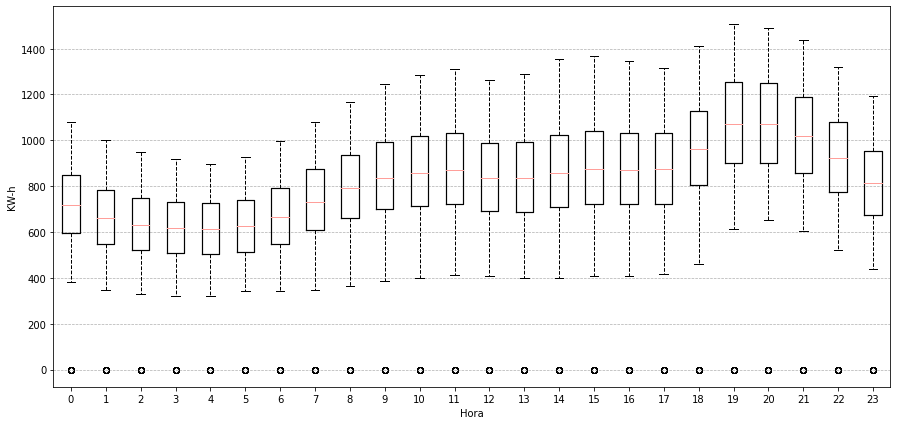

In [145]:
def box_plot_by_hour(data, figsize):
  fig, ax = plt.subplots(figsize=figsize)
  df = pd.DataFrame()
  for y in data.index.hour.unique():
    df[y] = data[data.index.hour == y].reset_index(drop=True)
  df.boxplot(whiskerprops = dict(linestyle='--', linewidth=1), 
                   boxprops= dict(linewidth=1.2), ax= ax)
  ax.set(xlabel='Hora', ylabel='KW-h');
  plt.grid(linestyle = '--', linewidth = 0.7)
  plt.grid(axis='x')
  plt.show()
box_plot_by_hour(train_full_bolivia, (15,7))

## **2.3 Análisis de normalidad**

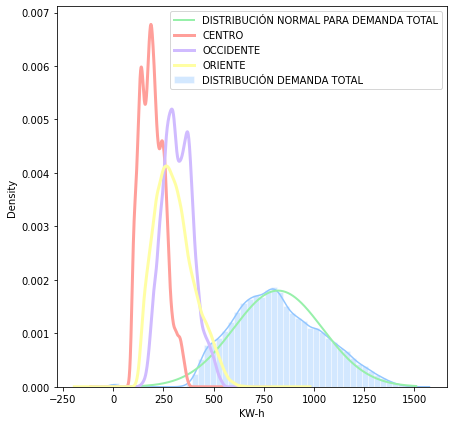

In [146]:
def plot_hist_and_normal(train_full, figsize,title = None, ax = None):
  if ax == None:
    fig, ax = plt.subplots(figsize=figsize)

  data = train_full.resample('h').sum()['KWH']
  sns.distplot(a= data,  
              hist_kws={"edgecolor": 'white'}, axlabel = 'KW-h', ax= ax, label="DISTRIBUCIÓN DEMANDA TOTAL")
  mu, sigma = stats.norm.fit(data)
  # Valores teóricos de la normal en el rango observado
  x_hat = np.linspace(min(data), max(data), num=500)
  y_hat = stats.norm.pdf(x_hat, mu, sigma)
  ax.plot(x_hat, y_hat, linewidth=2, label='DISTRIBUCIÓN NORMAL PARA DEMANDA TOTAL')
  ax.set_ylabel('Densidad de probabilidad')
  ax.set_title(title)
  train_full.groupby(['FECHA', 'ZONA'], as_index=False)['KWH'].sum().pivot(columns='ZONA',
                     values='KWH').plot.density(ax=ax,
                       linewidth = 3)
  ax.legend();

  # visualizing plot using matplotlib.pyplot library
  return ax

plot_hist_and_normal(train_full, (7,7))

Uno de los métodos gráficos más empleados para el análisis de normalidad consiste en representar los datos mediante un histograma y superponer la curva de una distribución normal con la misma media y desviación estándar que los datos disponibles.


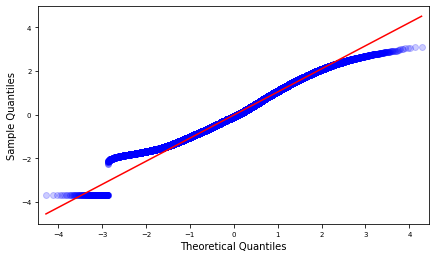

In [147]:
# Gráfico Q-Q
# ==============================================================================
def plot_qq(data, figsize = (7,4)):
  fig, ax = plt.subplots(figsize=figsize)
  sm.qqplot(
      data,
      fit   = True,
      line  = 'q',
      alpha = 0.2,
        lw    = 2,
      ax = ax
  )
  ax.tick_params(labelsize = 7)
  return ax
plot_qq(train_full_bolivia)

In [148]:
print('Kursotis:', stats.kurtosis(train_full_bolivia))
print('Skewness:', stats.skew(train_full_bolivia))

Kursotis: -0.2563365218779885
Skewness: 0.22384564164005835


Tiene una distribución platicurtica, y se encuentra moderadamente sesgada hacia la la cola derecha.

In [149]:
# normality test
stat, p = stats.shapiro(train_full_bolivia[:])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
print('H0: la muestra tiene una distribución Gaussian')
if p > alpha:
	print('la muestra parece Gaussian (No se puede rechazar H0)')
else:
	print('la muestra NO parece Gaussian (se rechaza H0)')

Statistics=0.988, p=0.000
H0: la muestra tiene una distribución Gaussian
la muestra NO parece Gaussian (se rechaza H0)


Los test de normalidad en general tienen problemas cuando la muestra tiende a ser muy grande (como este es el caso). Por otra parte, según el teorema del limite central y los datos recopilados por el Q-Q plot, Histograma, kurtosis y Skewness podemos asumir que los datos son suficientemente normales para el objetivo del trabajo.

## **2.4 Análisis de estacionalidad**

Text(0.5, 42.00000000000006, 'años')

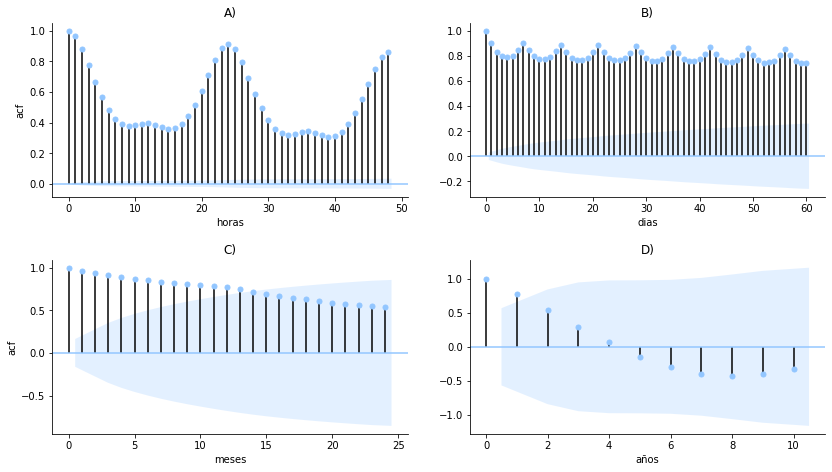

In [150]:
fig, axes = plt.subplots(ncols=2,nrows=2, figsize = (12,7))

plot_acf(train_full_bolivia, ax=axes[0,0], lags=48, title="A)")
plot_acf(train_full_bolivia.resample('d').mean(), ax=axes[0,1], lags=60, title="B)")
plot_acf(train_full_bolivia.resample('m').mean(), ax=axes[1,0], lags=24, title="C)")
plot_acf(train_full_bolivia.resample('y').mean(), ax=axes[1,1], lags=10, title="D)")
sns.despine()
fig.tight_layout(pad=3.0)
axes[0,0].set_ylabel('acf')
axes[1,0].set_ylabel('acf')
axes[0,0].set_xlabel('horas')
axes[0,1].set_xlabel('dias')
axes[1,0].set_xlabel('meses')
axes[1,1].set_xlabel('años')


In [151]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
    
    def ADF_Stationarity_Test(self, timeseries, printResults = True):
        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic',
            'P-Value','# Periodos usados','# Observaciones usadas'])
            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print('Augmented Dickey-Fuller Test Resultados:')
            print(dfResults)

In [152]:
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(train_full_bolivia.resample('d').mean(),
                            printResults = True)
print("¿La serie temporal es estacional? {0}".\
      format(sTest.isStationary))

Augmented Dickey-Fuller Test Resultados:
ADF Test Statistic          -1.447049
P-Value                      0.559524
# Periodos usados           31.000000
# Observaciones usadas    4351.000000
Critical Value (1%)         -3.431854
Critical Value (5%)         -2.862205
Critical Value (10%)        -2.567124
dtype: float64
¿La serie temporal es estacional? False


# **3. Preparación de los datos**

## **3.1 Missing data**

### **3.1.1 Encontrar datos faltantes**

In [153]:
np.unique(train_full_bolivia.resample('h').mean()\
          [train_full_bolivia.resample('h').mean() == 0].index.date)

array([datetime.date(2011, 6, 30), datetime.date(2012, 2, 22),
       datetime.date(2012, 5, 4), datetime.date(2012, 5, 5),
       datetime.date(2012, 5, 6), datetime.date(2012, 5, 7),
       datetime.date(2012, 7, 17), datetime.date(2014, 4, 11),
       datetime.date(2014, 4, 12)], dtype=object)

### **3.1.2 manejo de datos faltantes**
Se decidió realizar una interpolación linear dado que no son muchas las fechas que faltan

In [154]:
# Reemplazamos los ceros por NAN
data_prep = train_full_bolivia.copy()
data_prep.replace(0, np.nan, inplace=True)
data_prep = data_prep.resample('h').mean().\
interpolate(method= 'linear' )

In [155]:
np.unique(data_prep[data_prep == 0].index.date)

array([], dtype=object)

# **3.2 Separación de datos de entrenamiento** 

In [156]:
#train_size = int(0.7*len(data_prep.index))
#train_data, val_data = data_prep.iloc[:train_size], data_prep.iloc[train_size:]

In [157]:
def split_data(df, initial, horizonte_years=1,horizonte_meses=0,
               horizonte_dias = 0):
# initial as date
# horizonte
  index = df.index

  final_train = pd.to_datetime(initial)
  final_test = final_train + pd.DateOffset(years = horizonte_years,
                    months=horizonte_meses, days = horizonte_dias)
  cv = list()
  while final_test <= data_prep.index.max():
    array_train = index <= final_train
    array_test = (index > final_train) & (index <= final_test)
    cv.append((array_train, array_test))
    final_train = final_test
    final_test = final_train + pd.DateOffset(
        years = horizonte_years,months=horizonte_meses,
         days = horizonte_dias)
  array_train = index <= final_train
  array_test = (index > final_train) & (index <= final_test)
  cv.append((array_train, array_test))
  return cv

In [158]:
cv_split = split_data(data_prep, '2014-01-01')

# **4. Modelado**

## **4.1 Modelo de persistencia**

In [159]:
# persistence model
def model_persistence(x):
  return x
def persistence_model(data, test):
  # create lagged dataset Train
  persistencia = pd.concat([data.shift(365*24),
                            data], axis =1)
  persistencia.columns = ['t+1', 't']
  predictions = persistencia[test]
  return np.sqrt(mean_squared_error(predictions.t,
                                    predictions['t+1']))

In [160]:
model_persistence_results = list()
for cv in cv_split:
  model_persistence_results.append(\
                persistence_model(data_prep, cv[1]))
print("Resultado CV modelo de persistencia: {}".\
      format(np.mean(model_persistence_results)))

Resultado CV modelo de persistencia: 112.38928230564971


In [161]:
df_resultados = pd.DataFrame({'Modelo': [],
                           'Detalle':[],
                           'Parámetros':[],
                           'RMSE Val':[],
                           'RMSE Train':[]})

In [162]:
def load_evaluation (arr_to_add, df=df_resultados, order_by='RMSE Val'):
  r = df.shape[0]
  df.loc[r] = arr_to_add
  df.sort_values(by = order_by, ascending=False)
  return df

## **4.2 Modelo Prophet**

In [163]:
!pip install prophet

     |████████████████████████████████| 71kB 6.1MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 184kB 20.8MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6638460 sha256=9d1260ba39a3647f2d3402d93ea8bfcd167f80d22b5200ea877882ab996c1637
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [164]:
from prophet import Prophet
model_prophet = Prophet()
model_prophet.fit(pd.DataFrame({
    'ds': data_prep.index[cv_split[-1][0]],
    'y':data_prep[cv_split[-1][0]]}).reset_index(drop=True))

In [174]:
model_prophet_prediction = model_prophet.predict(\
                        pd.DataFrame({'ds':data_prep.index}))

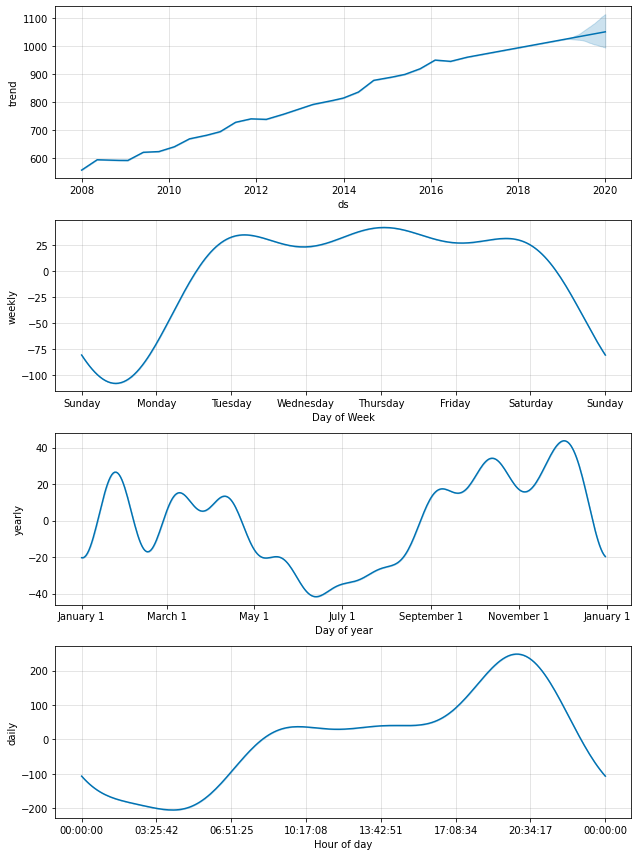

In [175]:
model_prophet.plot_components(model_prophet_prediction);

In [176]:
from prophet.diagnostics import cross_validation
cutoffs = pd.to_datetime(['2014-01-01', '2015-01-01',
                          '2016-01-01', '2017-01-01', '2018-01-01', '2018-12-31'])
df_cv2 = cross_validation(Prophet().fit(pd.DataFrame({
    'ds': data_prep.index,
    'y':data_prep}).reset_index(drop=True)),
    cutoffs=cutoffs, horizon='365 days', parallel="processes")

SystemError: ignored

In [ ]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv2)

In [135]:
np.sqrt(mean_squared_error(df_cv2.y, df_cv2.yhat))

75.35461882172848

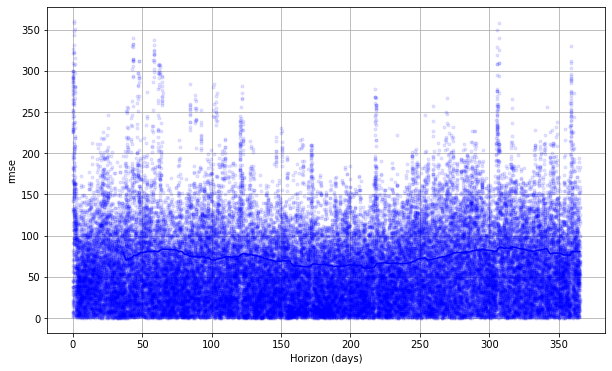

In [136]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv2, metric='rmse')

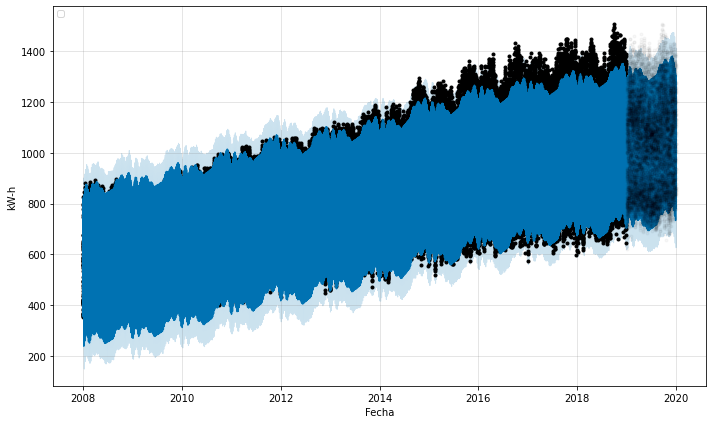

In [137]:
fig = model_prophet.plot(model_prophet_prediction)
ax = fig.gca()
ax.set_xlabel("Fecha")
ax.set_ylabel("kW-h")
ax.legend(loc='upper left', fontsize=8)
plt.plot(data_prep[cv_split[-1][1]], 'k.', alpha=0.03)

In [139]:
model_prophet_2 = Prophet(
    seasonality_mode = 'multiplicative',
    n_changepoints = 50,
    seasonality_prior_scale = 24,
)

In [140]:
df_cv3 = cross_validation(model_prophet_2.fit(pd.DataFrame({
    'ds': data_prep.index,
    'y':data_prep}).reset_index(drop=True)),
    cutoffs=cutoffs, horizon='365 days', parallel="processes")

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc7dfe3f790>


In [142]:
np.sqrt(mean_squared_error(df_cv3.y, df_cv3.yhat))

70.22149286173352

In [143]:
df_p_2_prophet = performance_metrics(df_cv3)

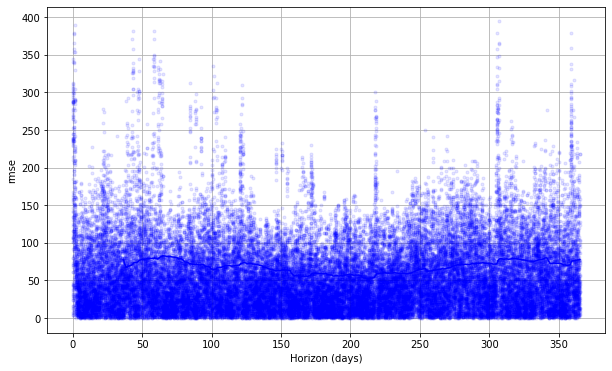

In [144]:
fig = plot_cross_validation_metric(df_cv3, metric='rmse')

In [148]:
model_prophet_3 = Prophet(
    seasonality_mode = 'multiplicative',
    n_changepoints = 50,
    seasonality_prior_scale = 24,
)
model_prophet_3.fit(pd.DataFrame({
    'ds': data_prep.index,
    'y':data_prep}).reset_index(drop=True))

In [149]:
model_prophet_prediction_3 = model_prophet_3.predict(\
                        pd.DataFrame({'ds':data_prep.index}))

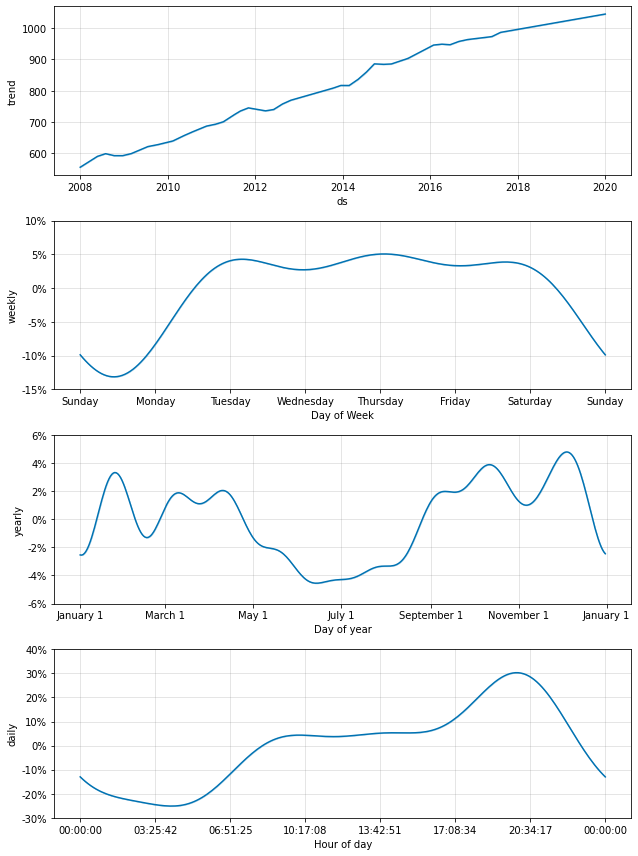

In [150]:
model_prophet_3.plot_components(model_prophet_prediction_3);

In [177]:
ny = pd.DataFrame({'holiday': "Año nuevo", 'ds' : pd.to_datetime(["2021-01-01","2020-01-01","2019-01-01","2018-01-01","2017-01-01","2016-01-01","2015-01-01","2014-01-01","2013-01-01","2012-01-01","2011-01-01","2010-01-01","2009-01-01","2008-01-01"]),'lower_window': 0,'upper_window': 1}) 
ny_aymara = pd.DataFrame({'holiday': "Año nuevo aymara", 'ds' : pd.to_datetime(["2021-06-21","2020-06-21","2019-06-21","2018-06-21","2017-06-21","2016-06-21","2015-06-21","2014-06-21","2013-06-21","2012-06-21","2011-06-21","2010-06-21","2009-06-21","2008-06-21"]),'lower_window': 0,'upper_window': 1})
carnaval = pd.DataFrame({'holiday': "Carnaval", 'ds' : pd.to_datetime(["2021-02-15","2021-02-16","2020-02-24","2020-02-25","2019-03-04","2019-03-05","2018-02-12","2018-02-13","2017-02-12","2017-02-13","2016-02-12","2016-02-13","2015-02-12","2015-02-13","2014-02-12","2014-02-13","2013-02-12","2013-02-13","2012-02-12","2012-02-13","2011-02-12","2011-02-13","2010-02-12","2010-02-13","2009-02-12","2009-02-13","2008-02-12","2008-02-13"]),'lower_window': 0,'upper_window': 1})
corpus = pd.DataFrame({'holiday': "corpus cristi", 'ds' : pd.to_datetime(["2021-06-03","2020-06-11","2019-06-20","2018-05-31","2017-05-31","2016-05-31","2015-05-31","2014-05-31","2013-05-31","2012-05-31","2011-05-31","2010-05-31","2009-05-31","2008-05-31"]),'lower_window': 0,'upper_window': 1})
independencia = pd.DataFrame({'holiday': "independencia", 'ds' :pd.to_datetime(["2021-08-06","2020-08-06","2019-08-06","2018-08-06","2017-08-06","2016-08-06","2015-08-06","2014-08-06","2013-08-06","2012-08-06","2011-08-06","2010-08-06","2009-08-06","2008-08-06"]),'lower_window': 0,'upper_window': 1})
dia_muertos = pd.DataFrame({'holiday': "dia de los muertos", 'ds': pd.to_datetime(["2021-11-02","2020-11-02","2019-11-02","2018-11-02","2017-11-02","2016-11-02","2015-11-02","2014-11-02","2013-11-02","2012-11-02","2011-11-02","2010-11-02","2009-11-02","2008-11-02"]),'lower_window': 0,'upper_window': 1})
dia_re_fundacion = pd.DataFrame({'holiday': "dia refundación", 'ds': pd.to_datetime(["2021-01-22","2020-01-22","2019-01-22","2018-01-22","2017-01-22","2016-01-22","2015-01-22","2014-01-22","2013-01-22","2012-01-22","2011-01-22","2010-01-22","2009-01-22","2008-01-22"]),'lower_window': 0,'upper_window': 1})
dia_del_trabajo = pd.DataFrame({'holiday': "dia del trabajo", 'ds': pd.to_datetime(["2021-05-01","2020-05-01","2019-05-01","2018-05-01","2017-05-01","2016-05-01","2015-05-01","2014-05-01","2013-05-01","2012-05-01","2011-05-01","2010-05-01","2009-05-01","2008-05-01"]),'lower_window': 0,'upper_window': 1})
navidad = pd.DataFrame({'holiday': "navidad", 'ds': pd.to_datetime(["2021-12-25","2020-12-25","2019-12-25","2018-12-25","2017-12-25","2016-12-25","2015-12-25","2014-12-25","2013-12-25","2012-12-25","2011-12-25","2010-12-25","2009-12-25","2008-12-25"]),'lower_window': 0,'upper_window': 1})
viernes_santo = pd.DataFrame({'holiday': "viernes santo", 'ds': pd.to_datetime(["2021-04-02","2020-04-10","2019-04-19","2018-03-30","2017-03-30","2016-03-30","2015-03-30","2014-03-30","2013-03-30","2012-03-30","2011-03-30","2010-03-30","2009-03-30","2008-03-30"]),'lower_window': 0,'upper_window': 1})
holidays = pd.concat((ny, ny_aymara, carnaval, corpus, independencia, dia_muertos, dia_re_fundacion, dia_del_trabajo, navidad, viernes_santo))

In [178]:
model_prophet_4 = Prophet(
    growth='linear',
    seasonality_mode = 'multiplicative',
    n_changepoints = 60,
    seasonality_prior_scale = 24,
    holidays = holidays
)

In [179]:
model_prophet_4.fit(pd.DataFrame({'ds': data_prep.index,
                    'y':data_prep}).reset_index(drop=True))

In [ ]:
df_cv3 = cross_validation(model_prophet_4,
    cutoffs=cutoffs, horizon='365 days', parallel="processes")

In [154]:
model_prophet_prediction_4 = model_prophet_4.predict(\
                        pd.DataFrame({'ds':data_prep.index}))

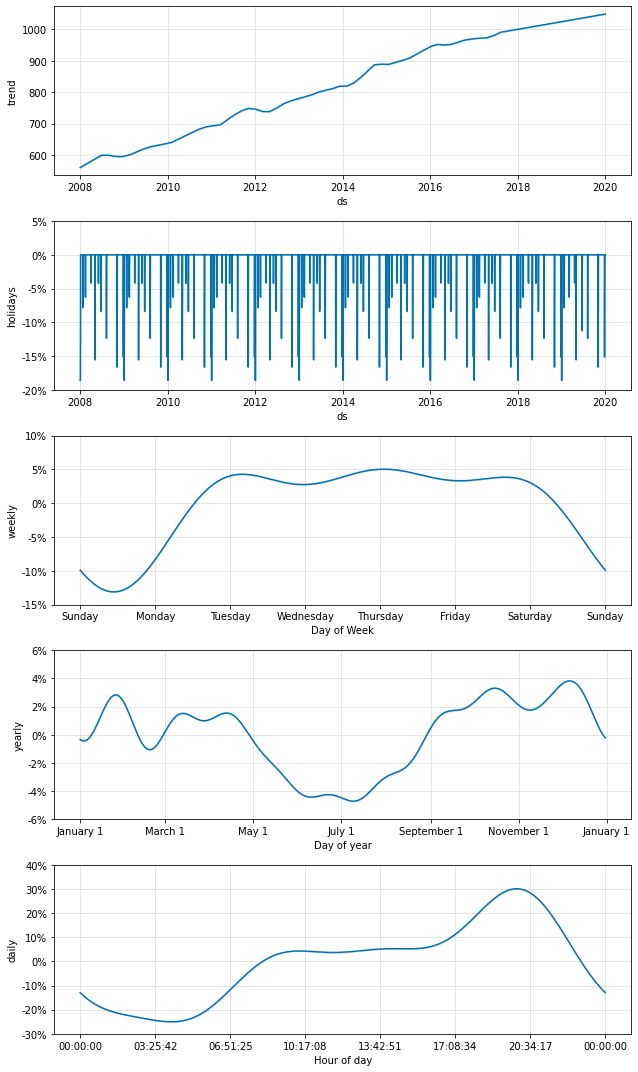

In [155]:
model_prophet_4.plot_components(model_prophet_prediction_4);

## **4.3 XGBoost**

In [168]:
def create_features_xgboost(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [169]:
X_train_xgboost, y_train_xgboost = create_features_xgboost(pd.DataFrame(data_prep), label='KWH')

In [170]:
Parametros= {'max_depth': [5, 6, 7, 8], 
             'learning_rate': [0.2, 0.1, 0.01]
             }
clf= GridSearchCV(xgb.XGBRegressor(n_jobs=-1),Parametros,
                 cv=cv_split, verbose=1, scoring='neg_mean_squared_error')

In [171]:
clf.fit(X_train_xgboost, y_train_xgboost)

Fitting 6 folds for each of 12 candidates, totalling 72 fits
[09:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[09:39:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:39:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:39:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:39:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  5.6min finished


[09:45:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=[(array([ True,  True,  True, ..., False, False, False]),
                  array([False, False, False, ..., False, False, False])),
                 (array([ True,  True,  True, ..., False, False, False]),
                  array([False, False, False, ..., False, False, False])),
                 (array([ True,  True,  True, ..., False, False, False]),
                  array([False, False, False, ..., False, False, False])),
                 (array([ True,  True,  True, ..., False, False, Fal...
                                    n_estimators=100, n_jobs=-1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.2, 0.1, 0.01],
                

In [172]:
np.sqrt(-clf.best_score_)

71.5418785242629

In [173]:
clf.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## **4.2 ARIMA Model**

### **4.1 Selección de rango de tiempo pará el modelo**

En general los modelos ARIMA no son muy eficientes cuando se utilizan muchos datos, por lo que intentaremos o cambiar la frecuencia de horas a días o incluso a meses. Otra opción es tomar una pequeña muestra de horas para realizar el entrenamiento.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7de3ad550>,
      dtype=object)

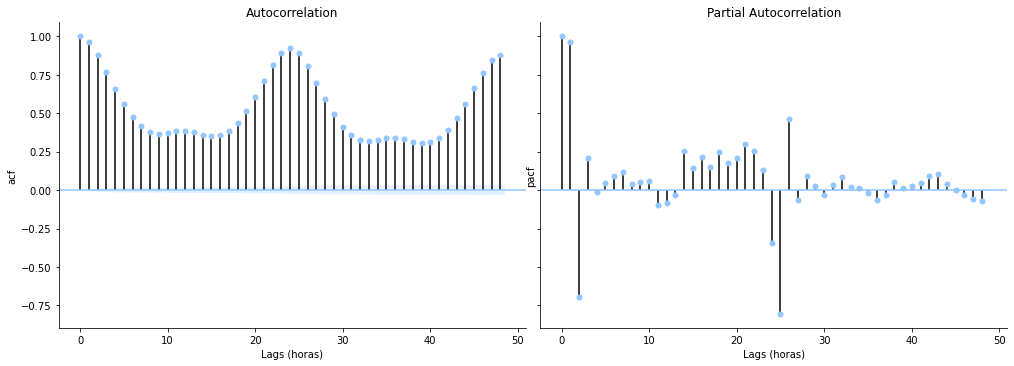

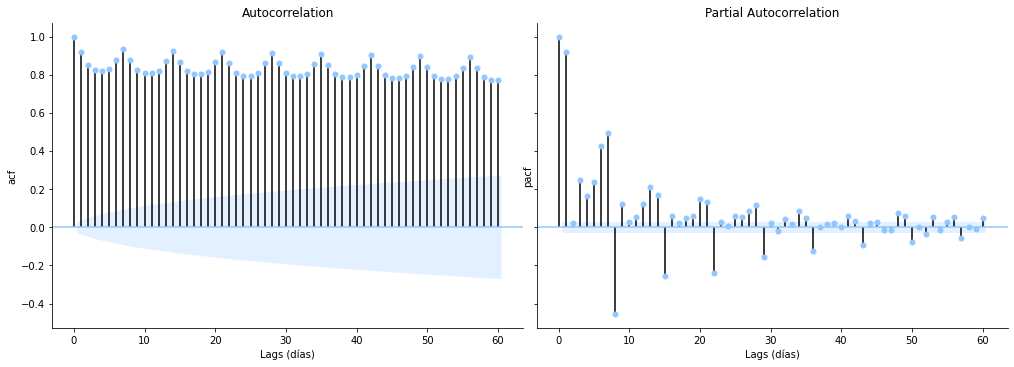

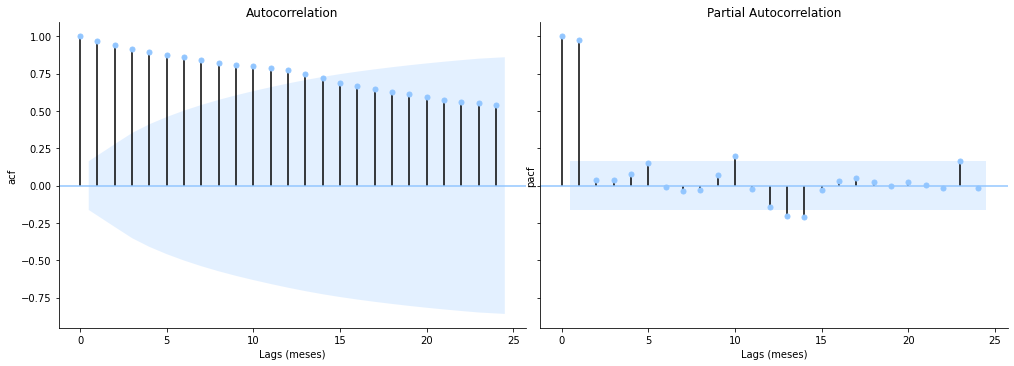

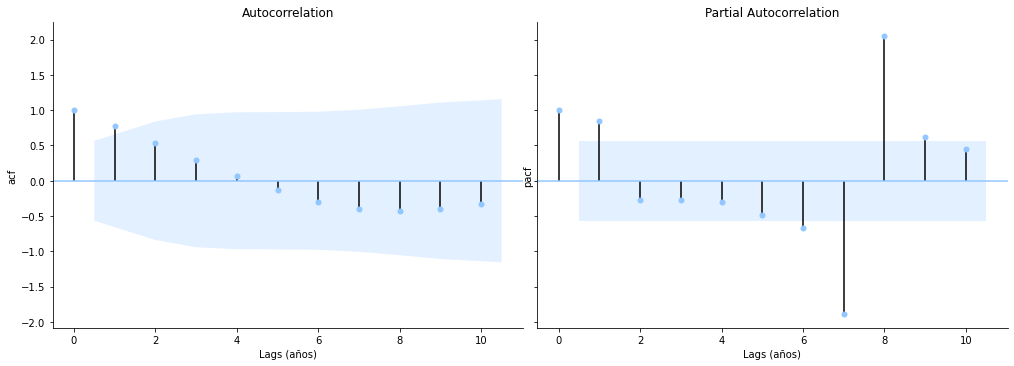

In [163]:
def tsplot2(y, lags=None, figsize=(14, 5), label = 'Lags'):
  fig, axes = plt.subplots(ncols=2, sharey = True, figsize = figsize)

  plot_acf(y, ax=axes[0], lags=lags)
  plot_pacf(y, ax=axes[1], lags=lags)
  sns.despine()
  plt.tight_layout()
  axes[0].set_ylabel('acf')
  axes[1].set_ylabel('pacf')
  axes[0].set_xlabel(label)
  axes[1].set_xlabel(label)
  return axes
tsplot2(data_prep, lags=48, label = 'Lags (horas)')
tsplot2(data_prep.groupby(pd.Grouper(freq='D')).mean(), lags=60, label = 'Lags (días)')
tsplot2(data_prep.groupby(pd.Grouper(freq='M')).mean(), lags=24, label = 'Lags (meses)')
tsplot2(data_prep.groupby(pd.Grouper(freq='A')).mean(), lags=10, label = 'Lags (años)')

### **4.2.1 Identificación de parámetros**

#### **4.2.1.1 Parametro de diferenciación d**

**Gráficos de diferenciación**

In [72]:
def plot_diff(df, lags = 24, grade=3, figsize=(30,14), label='Lags (horas)'):
  fig, axes = plt.subplots(ncols=3,nrows=grade, figsize = figsize)
  axes[0, 0].plot(df) ; axes[0, 0].set_title('Datos Originales')
  plot_acf(df, ax=axes[0, 1], lags=lags) ; axes[0, 1].set_title('ACF')
  plot_pacf(df, ax=axes[0,2], lags=lags) ; axes[0, 2].set_title('PACF')
  for g in range(1,grade):
    df = df.diff()
    axes[g, 0].plot(df) ; axes[g, 0].set_title('Datos de orden d=%d'%(g))
    plot_acf(df.dropna(), ax=axes[g, 1], lags=lags, title=None)
    plot_pacf(df.dropna(), ax=axes[g, 2], lags=lags, title=None) 
  for ax in axes.reshape(-1): 
    ax.set_xlabel(label)
  return axes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7de1846d0>,
      dtype=object)

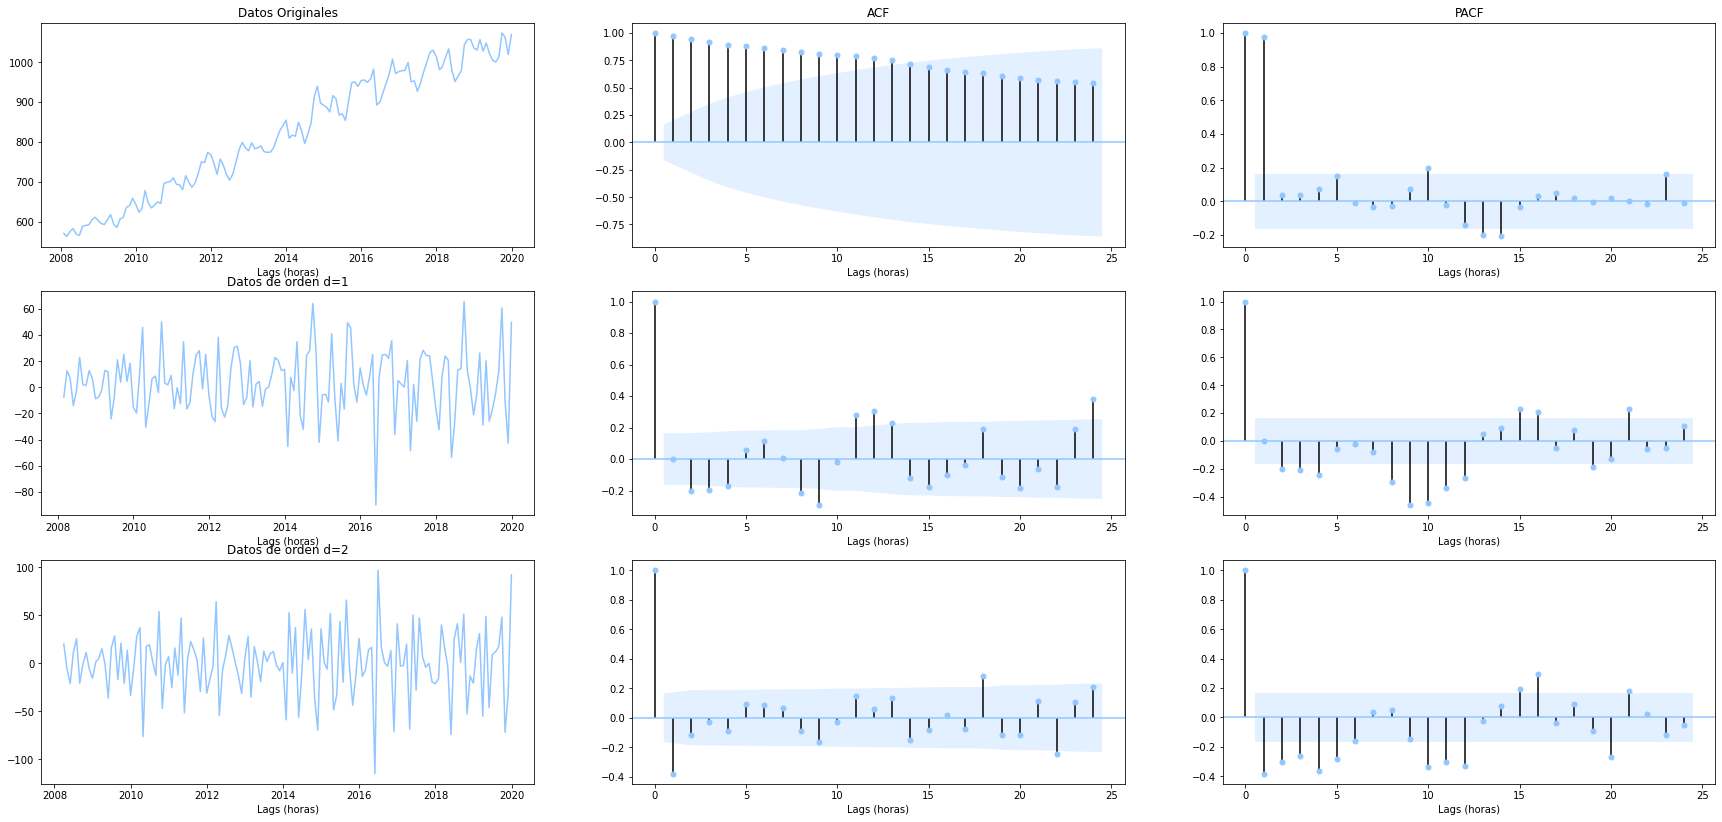

In [165]:
plot_diff(data_prep.resample('m').mean())

Para poder quitar la estacionalidad se define que un buen valor de diferenciación estaría entre 1 y 2. vamos a elegir el valor de 1 para evitar la sobre diferenciación.

#### **4.2.1.2 Parametro AR (p)**

Vasados en los gráfico PACF con d=1, el lag=1 presenta una buena correlación o el lag=24.

### **4.2.2 Modelado**

In [73]:
def plot_residuals_arima(residuals):
  fig, ax = plt.subplots(1,3, figsize=(21,7))
  residuals.plot(title="Error residual", ax=ax[0])
  residuals.plot(kind='kde', title='Densidad', ax=ax[1])
  plot_pacf(residuals, ax=ax[2], lags=48) ; ax[2].set_title('PACF')
  return ax

In [74]:
def plot_forcast_arima(model,interval_to_forcast, train_data, val_data, alpha = 0.05, figsize=(12,5)):
  fc, se, conf = model.forecast(interval_to_forcast, alpha=alpha)  # 95% conf

  # Make as pandas series
  fc_series = pd.Series(fc, index=val_data.index[:interval_to_forcast])

  # Plot
  plt.figure(figsize=figsize, dpi=100)
  plt.plot(train_data, label='Entrenamiento')
  plt.plot(val_data[:interval_to_forcast], label='actual')
  plt.plot(fc_series, label='forecast')
  #plt.fill_between(lower_series.index, lower_series, upper_series, 
  #                color='k', alpha=.15)
  plt.legend(loc='upper left', fontsize=8)
  plt.show()

In [169]:
model = ARIMA(data_prep, order=(0,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.KWH   No. Observations:               105191
Model:                 ARIMA(0, 1, 1)   Log Likelihood             -552028.660
Method:                       css-mle   S.D. of innovations             46.013
Date:                Tue, 15 Jun 2021   AIC                        1104063.320
Time:                        05:11:16   BIC                        1104092.011
Sample:                    01-01-2008   HQIC                       1104072.007
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0050      0.232      0.021      0.983      -0.451       0.461
ma.L1.D.KWH     0.6388      0.002    342.718      0.000       0.635       0.642
                                    Roots       

#### **4.2.2.1 Grid Search**

In [76]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
  # prepare training dataset
  history = [x for x in train]
  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out-of-sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  #rmse_train = sqrt(mean_squared_error(train, model_fit.predict(1, len(train),dynamic=True)))
  return rmse, predictions


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          rmse, predictions = evaluate_arima_model(train, test, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print( ' ARIMA%s RMSE=%.3f ' % (order,rmse))
        except:
          continue
  print( ' Best ARIMA%s RMSE=%.3f ' % (best_cfg, best_score))

#### **lag = 1 mes**

In [171]:
# evaluate parameters
p_values = range(0, 13)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(data_prep[cv_split[-1][0]].resample('m').mean(),data_prep[cv_split[-1][1]].resample('m').mean(), p_values, d_values, q_values)

 ARIMA(0, 0, 0) RMSE=223.395 
 ARIMA(0, 0, 1) RMSE=121.891 
 ARIMA(0, 1, 0) RMSE=30.932 
 ARIMA(0, 1, 1) RMSE=31.491 
 ARIMA(0, 1, 2) RMSE=26.518 
 ARIMA(0, 1, 3) RMSE=30.222 
 ARIMA(0, 1, 4) RMSE=30.701 
 ARIMA(0, 2, 0) RMSE=48.254 
 ARIMA(0, 2, 1) RMSE=31.237 
 ARIMA(0, 2, 2) RMSE=31.876 
 ARIMA(1, 0, 0) RMSE=31.551 
 ARIMA(1, 0, 1) RMSE=32.398 
 ARIMA(1, 0, 2) RMSE=28.382 
 ARIMA(1, 0, 3) RMSE=30.128 
 ARIMA(1, 0, 4) RMSE=608.333 
 ARIMA(1, 1, 0) RMSE=31.292 
 ARIMA(1, 2, 0) RMSE=45.028 
 ARIMA(2, 0, 0) RMSE=32.176 
 ARIMA(2, 0, 1) RMSE=31.737 
 ARIMA(2, 0, 2) RMSE=38.829 
 ARIMA(2, 0, 3) RMSE=51.771 
 ARIMA(2, 0, 4) RMSE=120.671 
 ARIMA(2, 1, 0) RMSE=29.271 
 ARIMA(2, 1, 2) RMSE=27.565 
 ARIMA(2, 2, 0) RMSE=39.210 
 ARIMA(3, 0, 0) RMSE=30.388 
 ARIMA(3, 0, 1) RMSE=30.083 
 ARIMA(3, 0, 2) RMSE=29.402 
 ARIMA(3, 0, 4) RMSE=35.211 
 ARIMA(3, 1, 0) RMSE=30.543 
 ARIMA(3, 1, 2) RMSE=27.837 
 ARIMA(3, 2, 0) RMSE=38.315 
 ARIMA(4, 0, 0) RMSE=31.467 
 ARIMA(4, 0, 1) RMSE=31.260 
 ARIMA(4, 

In [78]:
rmse_val, pred = evaluate_arima_model(data_prep[cv_split[-1][0]].resample('m').mean(),data_prep[cv_split[-1][1]].resample('m').mean(), (9,1,1) )
model = ARIMA(data_prep[cv_split[-1][0]].resample('m').mean(), order=(9,1,1))
model_fit = model.fit(disp=0)
pred_model_train = model_fit.predict(1, len(data_prep[cv_split[-1][0]].resample('m').mean()), typ='levels')
rmse_train = sqrt(mean_squared_error(data_prep[cv_split[-1][0]].resample('m').mean(), pred_model_train))

#load_evaluation(['ARIMA', 'mensual, dinámico','(12,1,0)', rmse_val, rmse_train] ,df = df_resultados)

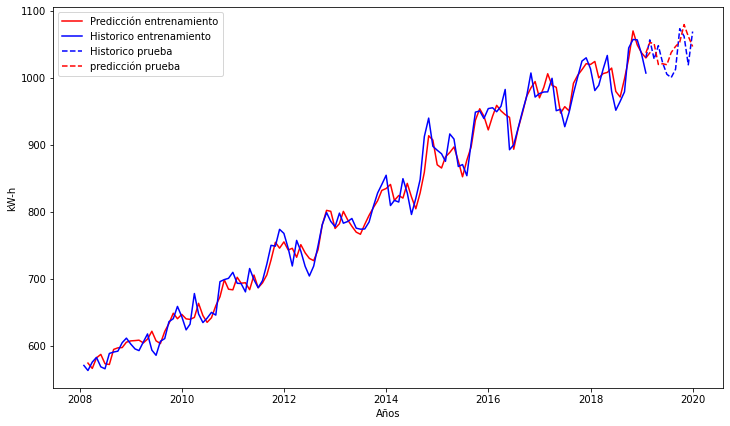

In [87]:
fig = plt.figure(figsize=(12,7))
plt.plot(pred_model_train, 'r', label = 'Predicción entrenamiento')
plt.plot(data_prep[cv_split[-1][0]].resample('m').mean(), 'b', label = 'Historico entrenamiento')
plt.plot(data_prep[cv_split[-1][1]].resample('m').mean(), 'b' '--', label = 'Historico prueba')
plt.plot(data_prep[cv_split[-1][1]].resample('m').mean().index, pred, 'r--', label = 'predicción prueba')
plt.xlabel('Años')
plt.ylabel('kW-h')
plt.legend()

In [112]:
train_residuals = pred_model_train.values - data_prep[cv_split[-1][0]].resample('m').mean().values

In [115]:
test_residuals = pd.DataFrame(pred).T.values - data_prep[cv_split[-1][1]].resample('m').mean().values

In [118]:
residuals = np.append(train_residuals, test_residuals)

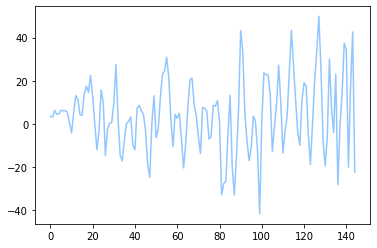

In [119]:
plt.plot(residuals)

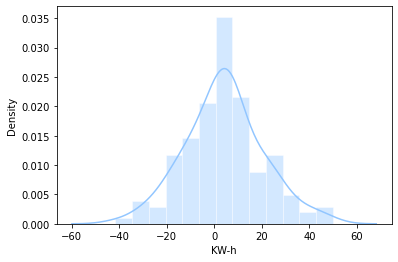

In [121]:
sns.distplot(a= residuals,  
              hist_kws={"edgecolor": 'white'}, axlabel = 'KW-h')

## **RNN**

In [44]:
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

def normalize_data(df):
    scaler = MinMaxScaler()
    df=scaler.fit_transform(df.values.reshape(-1,1))
    return df

In [57]:
data_prep_rnn = normalize_data(data_prep)
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[100000:]             
    y_test = y_train[100000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:100000]           
    y_train = y_train[:100000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (100000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [58]:
seq_len = 20 #choose sequence length
X_train, y_train, X_test, y_test = load_data(pd.DataFrame(data_prep), seq_len)
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (100000, 20, 1)
y_train.shape =  (100000,)
X_test.shape =  (5172, 20, 1)
y_test.shape =  (5172,)


In [59]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 20, 40)            1680      
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4

In [60]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
100/100 [==============================] - 30s 60ms/step - loss: 698344.9381
Epoch 2/10
100/100 [==============================] - 6s 59ms/step - loss: 684592.2704
Epoch 3/10
100/100 [==============================] - 6s 60ms/step - loss: 676454.2265
Epoch 4/10
100/100 [==============================] - 6s 60ms/step - loss: 671637.3218
Epoch 5/10
100/100 [==============================] - 6s 60ms/step - loss: 663501.5179
Epoch 6/10
100/100 [==============================] - 6s 59ms/step - loss: 659026.7358
Epoch 7/10
100/100 [==============================] - 6s 60ms/step - loss: 649414.0149
Epoch 8/10
100/100 [==============================] - 6s 60ms/step - loss: 646412.2290
Epoch 9/10
100/100 [==============================] - 6s 59ms/step - loss: 639481.3991
Epoch 10/10
100/100 [==============================] - 6s 59ms/step - loss: 632407.3546


In [62]:
from sklearn.metrics import r2_score
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  -29.190427592053787


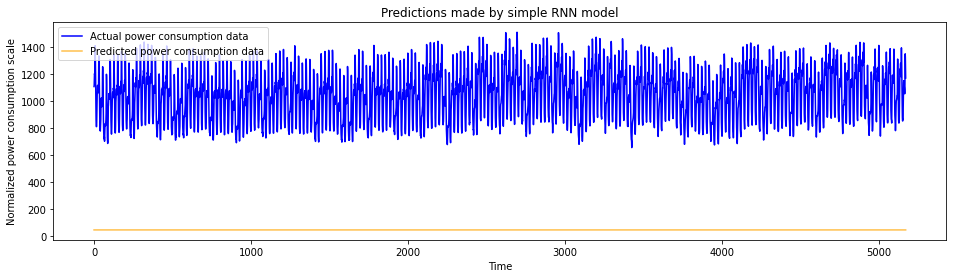

In [63]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

In [64]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 40)            6720      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [66]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=20, batch_size=500)

Epoch 1/20
200/200 [==============================] - 9s 23ms/step - loss: 620995.5429
Epoch 2/20
200/200 [==============================] - 5s 23ms/step - loss: 611638.3085
Epoch 3/20
200/200 [==============================] - 5s 23ms/step - loss: 597519.1598
Epoch 4/20
200/200 [==============================] - 5s 23ms/step - loss: 585185.0414
Epoch 5/20
200/200 [==============================] - 5s 23ms/step - loss: 574444.8971
Epoch 6/20
200/200 [==============================] - 5s 23ms/step - loss: 562988.6915
Epoch 7/20
200/200 [==============================] - 5s 23ms/step - loss: 550941.2052
Epoch 8/20
200/200 [==============================] - 5s 23ms/step - loss: 540138.2456
Epoch 9/20
200/200 [==============================] - 5s 23ms/step - loss: 528365.7486
Epoch 10/20
200/200 [==============================] - 5s 23ms/step - loss: 519631.4002
Epoch 11/20
200/200 [==============================] - 5s 23ms/step - loss: 506523.2085
Epoch 12/20
200/200 [====================

In [70]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  -20.488409575224015


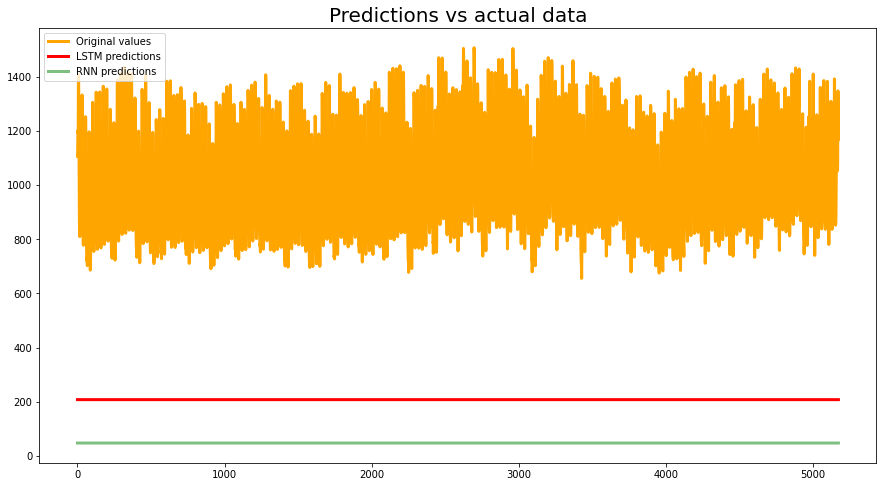

In [71]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()

# **Prueba Final** 

In [180]:
model_prophet_prediction_final = model_prophet_4.predict(\
                        pd.DataFrame({'ds':test_bolivia.index}))

In [189]:
np.sqrt(mean_absolute_error(test_bolivia.values,
                            model_prophet_prediction_final.yhat.values))

10.213542105195872

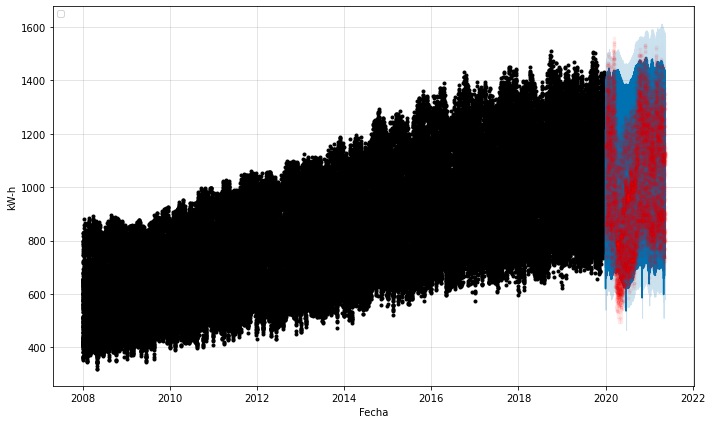

In [194]:
fig = model_prophet_4.plot(model_prophet_prediction_final)
ax = fig.gca()
ax.set_xlabel("Fecha")
ax.set_ylabel("kW-h")
ax.legend(loc='upper left', fontsize=8)
plt.plot(test_bolivia, 'r.', alpha=0.05)